### Описание проекта:
`1. Тип задачи:` <br>сегментация изображений (поиск рта на фотографиях людей). Исходный датасет доступен по ссылке:
https://www.kaggle.com/datasets/olekslu/makeup-lips-segmentation-28k-samples <br>
`2. Ограничение:`<br>
Для увеличения скорости обработки исходные изображения (их можно скачать и посмотреть из папки "set-lipstick-original") в коде уменьшаются в 4 раза. Изображения загружаются в оперативную память непосредственно в момент их использования нейросетью. В противном случае датасет не поместится в память. <br>
`3. Реализация проекта:`<br>
- Скачивание исходного датасета с изображениями и масками.
- Создание класса DataSet. На вход класс принимает пути к снимкам. При выводе изображения происходит reshape изображения, цвета масок приводятся к одному "цвету" (в исходных изображениях имелись незначительные колебания гаммы цвета, преобразовал все маски к (255, 255, 255)).
- Создание класса DataLoader.
- Выбор предобученной модели для сегментации. Загрузка модели в проект, преобразования выходящих слоев к необходимой размерности.
- Обучение модели. В качестве метрики и функции loss использовалась функция DICE.<br>

`4. Дальнейшее развитие модели, улучшение показателей:`<br>
- выбор иного оптимизатора
- выбор иной предобученной модели
- вставка дополнительных слоев (необходимо посмотреть распространение градиента)
- Аугументация исходных изображений, масштабирование, вырезки часте ихображений и иные преобразования исходных данных.
- Использование stacking - моделей нейросетей.

##### 1. Установка и импорт библиотек

In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
from google.colab.patches import cv2_imshow
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt
import torch
from torchsummary import summary
import segmentation_models_pytorch as smp
from torch.optim import Adam
from torch.multiprocessing import set_start_method
import numpy as np
import gc
from torchsummary import summary

In [ ]:
set_start_method('spawn')

##### 2. Выбор среды для обучения модели: GPU или CPU

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_properties(device))
else:
    print('using CPU')
    device = torch.device('cpu')

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


##### 3. Подготовка датасета к обучению:

In [ ]:
path_to_images = r'./set-lipstick-original/720p'
path_to_masks = r'./set-lipstick-original/mask'

In [ ]:
info_dataframe = pd.read_csv(r'./set-lipstick-original/list.csv', sep=',', encoding='utf-8')
info_dataframe.head(3)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png


In [ ]:
### drop bad image
info_dataframe = info_dataframe[info_dataframe['filename'] != 'image00000616.jpg']

###### Проверка, что все пары изображение - маска присутствуют на диске.
Если найдены отсутствующие изображения или маски - записи удалятся из Датафрейма

In [ ]:
print(f'До удаления было {info_dataframe.shape[0]} записей')

available_images = os.listdir(path_to_images)
available_masks = os.listdir(path_to_masks)

info_dataframe = info_dataframe[info_dataframe['filename'].isin(available_images)]
info_dataframe = info_dataframe[info_dataframe['mask'].isin(available_masks)]
print(f'После удаления стало {info_dataframe.shape[0]} записей')

До удаления было 28593 записей
После удаления стало 28539 записей


In [ ]:
x, y = info_dataframe['filename'], info_dataframe['mask']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=1)

##### Описание класса датасета:
Класс на вход принимает:
- названия изображений,
- названия масок,
- выходной рвзмер изображения (устанавливается в соответствии с требованиями предобученной сети)
- пути к папкам с изображениями и маскамии,
- устройство для дальнейшей обработки (CPU или GPU)
- параметр загрузки датасета в оперативную память. Данный параметр необходим для контроля над оперативной паматью: в датасете почти 30 000 изображений, в памяти они занимают очень много места. В связи с этим было принято решение при обработке каждый снимок отдельно считывать с диска и передавать на обучение



In [ ]:
class ImageDataSet(Dataset):
    def __init__(self, image_names:pd.Series, mask_names:pd.Series, path_to_images:str, path_to_masks:str, output_img_height:int, output_img_width:int, device, load_dataset_to_memory=False):
        self.transform_image = transforms.Compose([transforms.Resize((output_img_height, output_img_width)),                     # преобразование размера изображения
                                                  transforms.ToTensor(),                                                      # перенос изображения в тензор
                                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  # нормализация каналов изображения
        self.transform_mask = transforms.Compose([transforms.Resize((output_img_height, output_img_width)),
                                                  transforms.ToTensor()])
        self.device = device
        self.load_dataset_to_memory = load_dataset_to_memory

        self.images = pd.DataFrame(image_names)
        self.images['path'] = self.images['filename'].apply(lambda x: f'{path_to_images}/{x}')
        self.images.reset_index(inplace=True, drop=True)
        if load_dataset_to_memory:
            self.images['stored_image'] = self.images['path'].apply(lambda x: ImageDataSet.load_picture(x, self.transform_image))

        self.masks = pd.DataFrame(mask_names)
        self.masks['path'] = self.masks['mask'].apply(lambda x: f'{path_to_masks}/{x}')
        self.masks.reset_index(inplace=True, drop=True)
        if load_dataset_to_memory:
            self.masks['stored_mask'] = self.masks['path'].apply(lambda x: ImageDataSet.load_picture(x, self.transform_mask, 'mask'))

    @staticmethod
    def load_picture(path_to_picture, transformer, key='image'):
    # процедура считывания изображения с диска и преобразования его
        picture = Image.open(path_to_picture)
        picture = transformer(picture)
        if key == 'mask':
            picture = ImageDataSet.enhance_mask(picture)
        return picture

    @staticmethod
    def rgb2gray(rgb):
        # процедура конвертации rgb to gray - используется только для масок
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray

    @staticmethod
    def enhance_mask(mask):
        # Процедура задания все целевым пикселя маски цвета 1
        mask = mask.cpu().numpy()
        mask = mask.transpose(1,2,0)
        mask = ImageDataSet.rgb2gray(mask)
        mask[mask > 0] = 1
        return torch.from_numpy(mask)

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        if self.load_dataset_to_memory:
            image=self.images.iloc[index]['stored_image']
            mask=self.masks.iloc[index]['stored_mask']
        else:
            image = ImageDataSet.load_picture(self.images.iloc[index]['path'], self.transform_image)
            mask = ImageDataSet.load_picture(self.masks.iloc[index]['path'], self.transform_mask, 'mask')
        return image.to(self.device), mask.to(self.device)


In [ ]:
train_dataset = ImageDataSet(x_train, y_train, path_to_images, path_to_masks, 192, 320, device)
test_dataset = ImageDataSet(x_test, y_test, path_to_images, path_to_masks, 192, 320, device)

##### 4. Демонастрация исходных данных, получаемых из сформированного датасета:
- левая картинка - исходное изображение (цвет изображения отличается от исходного, т.к. для работы с предобученными сетями необходимо провести нормализацию данных)
- правая картинка - целевое предсказание (маска)

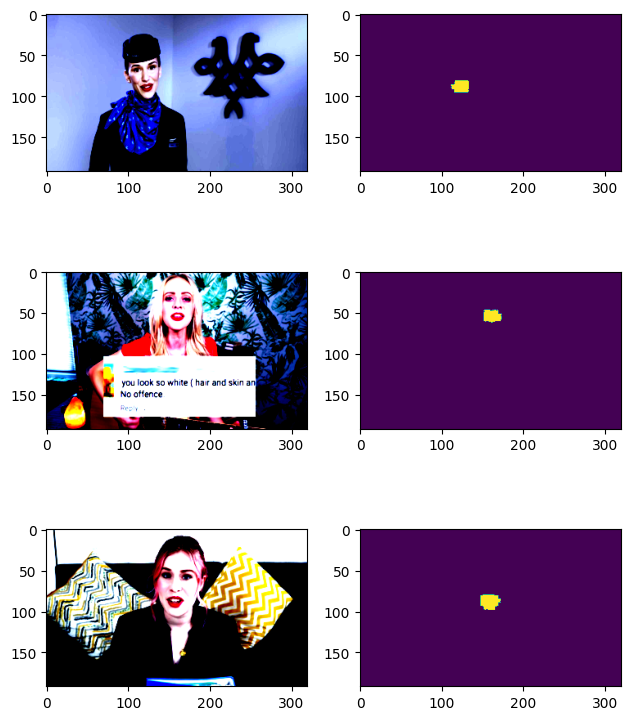

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.subplots_adjust(bottom = 0.15, right = 0.7)

index = 0
img, mask = train_dataset.__getitem__(index)
axes[0, 0].imshow(img.cpu().permute(1, 2, 0))
axes[0, 1].imshow(mask.cpu())

index = 10001
img, mask = train_dataset.__getitem__(index)
axes[1, 0].imshow(img.cpu().permute(1, 2, 0))
axes[1, 1].imshow(mask.cpu())

index = 19000
img, mask = train_dataset.__getitem__(index)
axes[2, 0].imshow(img.cpu().permute(1, 2, 0))
axes[2, 1].imshow(mask.cpu())

plt.gcf().set_size_inches(10, 10)

##### 5. Подготовка данных к обработке: продолжение:
- Создание класса загрузчика (DataLoader)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=0, drop_last=True)

##### 6. Подготовка модели к обучению
В качестве модели для обучения используется предобученная на датасете ImageNet модель Unet. Обученные параметры зафиксированы.

В качестве функции потерь использовалась функция (1-Dice), в качестве метрики использовалась функция Dice

In [ ]:
BACKBONE = 'resnet34'
segmodel = smp.Unet(BACKBONE, classes=1, activation='sigmoid', encoder_weights='imagenet').to(device)

for param in list(segmodel.encoder.parameters())[:]:
    param.requires_grad = False

In [ ]:
summary(segmodel.to(device), input_size=(3, 192, 320))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 96, 160]           9,408
       BatchNorm2d-2          [-1, 64, 96, 160]             128
              ReLU-3          [-1, 64, 96, 160]               0
         MaxPool2d-4           [-1, 64, 48, 80]               0
            Conv2d-5           [-1, 64, 48, 80]          36,864
       BatchNorm2d-6           [-1, 64, 48, 80]             128
              ReLU-7           [-1, 64, 48, 80]               0
            Conv2d-8           [-1, 64, 48, 80]          36,864
       BatchNorm2d-9           [-1, 64, 48, 80]             128
             ReLU-10           [-1, 64, 48, 80]               0
       BasicBlock-11           [-1, 64, 48, 80]               0
           Conv2d-12           [-1, 64, 48, 80]          36,864
      BatchNorm2d-13           [-1, 64, 48, 80]             128
             ReLU-14           [-1, 64,

In [ ]:
# Функция расчета метрики и функции потерь для обучения
class Dice(torch.nn.Module):
    def __init__(self, weight=None, size_average=True, option='loss'):
        super(Dice, self).__init__()
        self.option=option

    def forward(self, logits, targets):
        smooth = 0.0001
        num = targets.size(0)
        m1 = logits.reshape(num, -1)
        m2 = targets.reshape(num, -1)
        intersection = (m1 * m2).sum(1)
        common_square = m1 + m2
        common_square[common_square>1] = 1
        common_square = common_square.sum(1)
        score = (intersection + smooth) / (common_square + smooth)
        score = (score.sum() / num)
        if self.option == 'loss':
            return 1 - score
        else:
            return score

In [ ]:
criterion = Dice()
metric = Dice(option='metric')
optimizer = Adam(segmodel.parameters(), lr=0.001)

##### 7. Обучение модели:

In [ ]:
num_epochs = 3
# train_loss = []
# train_metric = []
# test_metric = []

segmodel.train().to(device)
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        # обнуляем градиент
        optimizer.zero_grad()

        outputs = segmodel(data[0])

        loss = criterion(outputs, data[1])
        loss.backward(retain_graph=True)

        optimizer.step()

        # выводим статистику о процессе обучения
        if i % 156 == 0:    # печатаем каждые 156 mini-batches
            segmodel.eval().to(device)
            for j, test_data in enumerate(test_loader):
                if j == 1:
                    break
                test_outputs = segmodel(test_data[0])

                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}]')
                print(f'train loss={loss: .4f}' )
                print(f'train DICE={metric(outputs, data[1]): .4f}')
                print(f'Test DICE: {metric(test_outputs, test_data[1]): .4f}\n')

            segmodel.train().to(device)

print('Training is finished!')

Epoch [1/3], Step [1/624]
train loss= 0.9363
train DICE= 0.0637
Test DICE:  0.0871

Epoch [1/3], Step [157/624]
train loss= 0.1746
train DICE= 0.8254
Test DICE:  0.8526

Epoch [1/3], Step [313/624]
train loss= 0.1135
train DICE= 0.8865
Test DICE:  0.8707

Epoch [1/3], Step [469/624]
train loss= 0.0982
train DICE= 0.9018
Test DICE:  0.9125

Epoch [2/3], Step [1/624]
train loss= 0.0886
train DICE= 0.9114
Test DICE:  0.9133

Epoch [2/3], Step [157/624]
train loss= 0.0889
train DICE= 0.9111
Test DICE:  0.9266

Epoch [2/3], Step [313/624]
train loss= 0.0648
train DICE= 0.9352
Test DICE:  0.9463

Epoch [2/3], Step [469/624]
train loss= 0.0713
train DICE= 0.9287
Test DICE:  0.9407

Epoch [3/3], Step [1/624]
train loss= 0.0748
train DICE= 0.9252
Test DICE:  0.9416

Epoch [3/3], Step [157/624]
train loss= 0.0682
train DICE= 0.9318
Test DICE:  0.9461

Epoch [3/3], Step [313/624]
train loss= 0.0528
train DICE= 0.9472
Test DICE:  0.9489

Epoch [3/3], Step [469/624]
train loss= 0.0549
train DICE= 0

##### 8. Демонстрация полученных результатов:

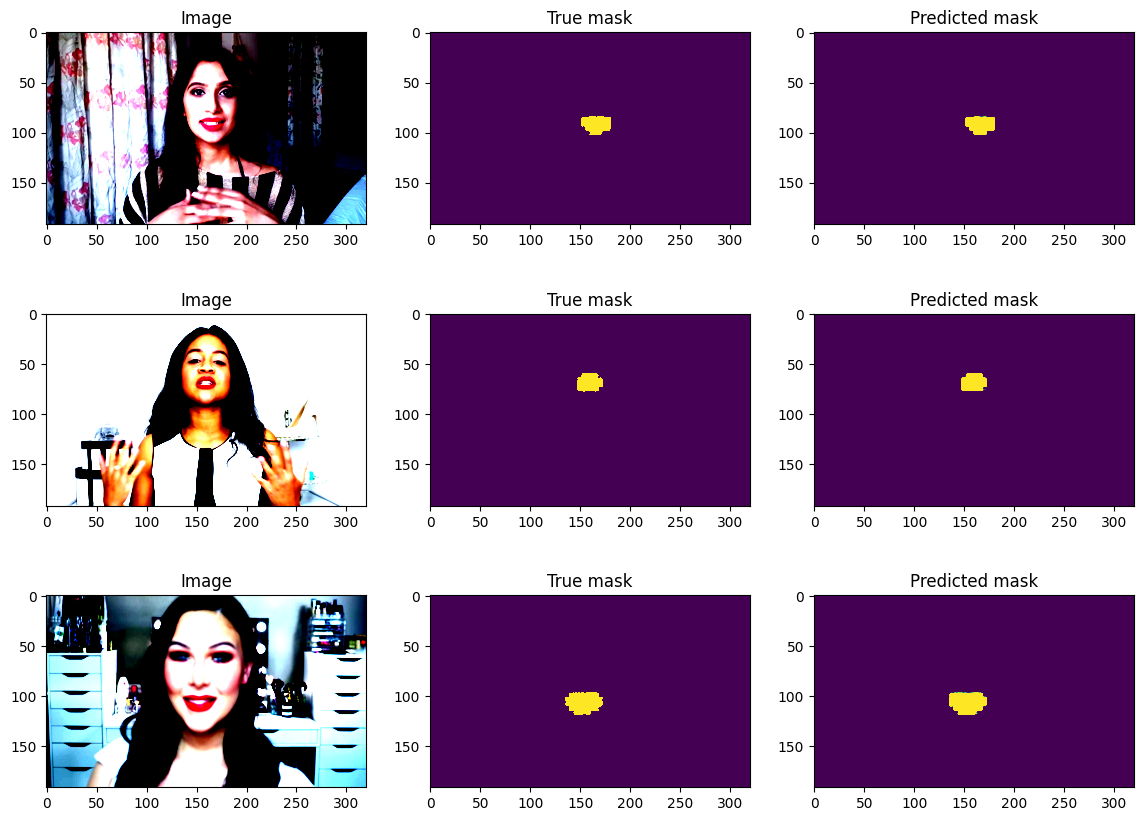

In [ ]:
segmodel.eval().to(device)
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.subplots_adjust(bottom = 0.5, right = 0.85)
plt.gcf().set_size_inches(15,21)

index = 10
img, mask_true = test_dataset.__getitem__(index)
mask_pred = segmodel.predict(img[None, :, :, :])
axes[0, 0].imshow(img.cpu().permute(1, 2, 0))
axes[0, 1].imshow(mask_true.cpu())
axes[0, 2].imshow(torch.squeeze(mask_pred.cpu()))
axes[0, 0].set_title('Image')
axes[0, 1].set_title('True mask')
axes[0, 2].set_title('Predicted mask')

index = 100
img, mask_true = test_dataset.__getitem__(index)
mask_pred = segmodel.predict(img[None, :, :, :])
axes[1, 0].imshow(img.cpu().permute(1, 2, 0))
axes[1, 1].imshow(mask_true.cpu())
axes[1, 2].imshow(torch.squeeze(mask_pred.cpu()))
axes[1, 0].set_title('Image')
axes[1, 1].set_title('True mask')
axes[1, 2].set_title('Predicted mask')

index = 500
img, mask_true = test_dataset.__getitem__(index)
mask_pred = segmodel.predict(img[None, :, :, :])
axes[2, 0].imshow(img.cpu().permute(1, 2, 0))
axes[2, 1].imshow(mask_true.cpu())
axes[2, 2].imshow(torch.squeeze(mask_pred.cpu()))
axes[2, 0].set_title('Image')
axes[2, 1].set_title('True mask')
axes[2, 2].set_title('Predicted mask')

plt.show()

##### 9. Возврат к исходной размерности изображений:

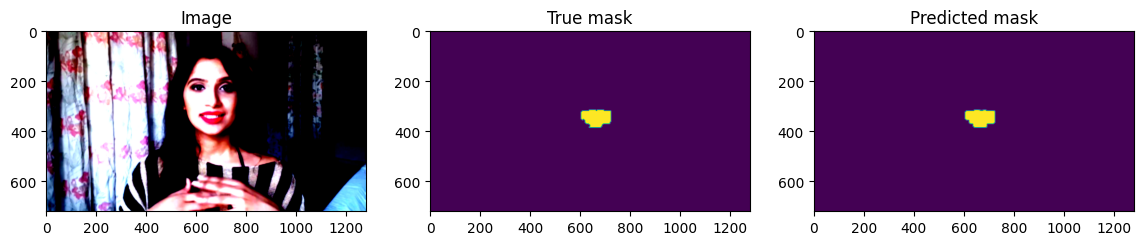

In [ ]:
segmodel.eval().to(device)
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.subplots_adjust(bottom = 0.5, right = 0.85)
plt.gcf().set_size_inches(15,21)

index = 10
img, mask_true = test_dataset.__getitem__(index)
mask_pred = segmodel.predict(img[None, :, :, :])

img = transforms.Resize((720, 1280))(img)
mask_true = transforms.Resize((720, 1280))(mask_true[None, :, :])
mask_pred = transforms.Resize((720, 1280))(mask_pred)

axes[0].imshow(img.cpu().permute(1, 2, 0))
axes[1].imshow(torch.squeeze(mask_true.cpu()))
axes[2].imshow(torch.squeeze(mask_pred.cpu()))
axes[0].set_title('Image')
axes[1].set_title('True mask')
axes[2].set_title('Predicted mask')
plt.show()

##### 10. Вывод:
Была обучена нейросеть для сегментации рта на фотографиях людей. Качество модели (метрика Dice) составила 95%. Визуальная оценка изображений также удовлетворяет, однако заметен дефект - при возврате к исходной размерности изображений предсказанная маска также покрывает внутренности рта - зубы и т.д. Улучшить качество предсказанной маски можно обучив модель не на уменьшенных изображениях, а на исходных (в моем случае не хватило объема оперативной памяти)